# Explanation on generator design choices. 

**Don't look if you don't want spoilers!**

This notebook covers the design choices of the [data generator](#Data-generator) (and [changes for the regenerator](#Data-re-generator). If you're looking for an exploratory analysis of the data, look **HERE**. If you're looking for the experimental plan and analysis, look **HERE**.

# (!) add jump links to sections?

### Why we need a generator

**Why I wanted to do this project**

Before I learned to program / decided I wanted to learn to do data science, I ran user-testing programs for hardware products at a tech company. There are a lot of people getting into data science, and while I still feel like a beginner at programming, I'm pretty confident in my business background. So I wanted a project to show that. When I first started, this project had almost nothing to do with business, but it just kind of bled through - the connections were already there.

--> so maybe it's better to just say that? think about the message and try to get it clear.
--> I also like this stuff anyway - ask me about the case study I wrote for a business fraternity in 2018. (I picked this restaurant because I thought the name was funny - I was going to use another restaurant I also wrote a case about called the Himalayan Chimney, but they changed their website to just an ordering screen because of covid, which wasn't as fun).

**Showcasing A/B testing is hard**

Anyway, it's hard to showcase A/B testing because you need a product and users. And every company seems to want A/B testing experience. So instead of giving up, I found a sneaky way around it. When a company does A/B testing, they just look at the data to see how users interact with a change. So instead of actually implementing a change and looking at the data, we can just regenerate data for a month and pretend that's the sales data from the users. It's just order data, so it's not as good as real-time user data (like click-through-rates or stuff like that), but it's not likely most restaurants will have that kind of data either - it's a nice, simple example.

--> also gives us a chance to talk about the difference between a/b testing and other types of user testing
--> don't forget about the pitfalls of A/B testing! How does that apply to this case?

**Notebooks are independent**

In each workbook, we assume we have no knowledge of other notebooks.

A truer chronological workflow might look like this:

1. Get data
    1. Write generator, generate data [data_generator.py]
    2. Document generator design [generator_explanation.ipynb]
    
    
2. Explore data
    1. Explore, validate data (suggest business recs / potential tests) [data_analysis.ipynb]
    
    
3. Design test
    1. Design experiment for accepted tests [experiment_analysis.ipynb]
    
    
4. Implement test
    1. Regenerate data for test [data_generator.py]
    2. Document re-generator design [generator_explanation.ipynb]
    
    
5. Evaluate findings
    1. Analyze experiment, explain findings [experiment_analysis.ipynb]

### Generator key questions

We don't have ThaiTanic's actual data, but we can use some market sizing tricks to get a decent estimate. There are several pieces of information we need to figure out:

1. How many orders does the restaurant get per month?
2. What do people spend on orders?

We can answer the first through market sizing, and the second by making our best guess based on what's on their menu (I asked some friends for input too!). And then we'll add some random variation to the values.

--> this section can probably be trimmed or just combined.

# Setup

Essentially the same setup that happens in the analysis - we need this to validate our generator later.

In [1]:
import pandas as pd
pd.options.display.max_rows = 10  # limit huge ouputs
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # plt.style.available

import warnings
warnings.filterwarnings("ignore")  # filter warnings

In [2]:
path = "../data/raw_data/"

all_months_data = pd.DataFrame()

for file in os.listdir(path):
    if not file.startswith('.'):  # ignore hidden files
        current_month_data = pd.read_csv(path+file)
        all_months_data = pd.concat([all_months_data, current_month_data])

# remove unnamed column (fixed for future generations!)
df = all_months_data.loc[:, ~all_months_data.columns.str.contains('^Unnamed')]

In [3]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Weekday Value'] = df['Order Date'].dt.weekday

df['Hour'] = df['Order Date'].dt.hour

![](..\\revenue_model.jpg)

# Conceptual revenue model


Let's consider a revenue model for the restaurant.

![](..\\revenue_model.jpg)

Their revenue is basically the number of orders times the cost per order. 





**combined from above:**

### Generator key questions

We don't have ThaiTanic's actual data, but we can use some market sizing tricks to get a decent estimate. There are several pieces of information we need to figure out:

1. How many orders does the restaurant get per month?
2. What do people spend on orders?

We can answer the first through market sizing, and the second by making our best guess based on what's on their menu (I asked some friends for input too!). And then we'll add some random variation to the values.

In [11]:
d = os.getcwd()
d = os.chdir("..")
d

# 1. How many orders does the restaurant get per month?

We can answer this with market sizing.

We're making a month csv at a time because that seems pretty reasonable.

__Order:__
1. Market sizing
    1. Seating count
    2. Dining time
    3. Delivery/takeout
    
    
2. Popular times (we generate by hour!)

4. Annual, seasonal multipliers
    1. Annual multiplier --> just make future years slightly bigger to show growth over time
    2. Seasonal multiplier --> winter months are max?

# Data generator

### Market sizing

Seating count, dining time, delivery/takeout

The idea was to size the total amount

### Popular times (by hour)

Used Google popular times to estimate orders per hour. Assigned weights and assumed 0 value gives 50%.

Huge variance - busiest day is almost 3x as busy as least busy day.

---

I noticed Google has "popular_times" values for the restaurant. There isn't really a scale, but I can use these to approximate restaurant occupancy to the hour instead of to the day.

I'm not sure how specific these are to 2020 - they seem a little low to me, but I figured it's fine because I'm just estimating and I'll throw in variance anyway.

##### (!) should I add in variance in the years? and the months?! how did i miss that?

##### (!) add in a visualization that shows the min/max values vs. the average weighted values we have? that would be a cool graph! (would belong in this notebook).

### Annual/seasonal multipliers

Year multiplier, summer/winter month multiplier. Mostly negative.

### Chance for additional item in order

If ordering starter or dessert, there's a chance for an additional item. 

### Chance for increased order quantity

### Generating by hour

Tried by month (because csvs are by month), but "accuracy" to the hour made more sense. Added variance with normal distribution.

### Weights for menu (by category, by item)

Categories have weights, and then within the category the items have weights.

# (!) need to validate the total number of orders!

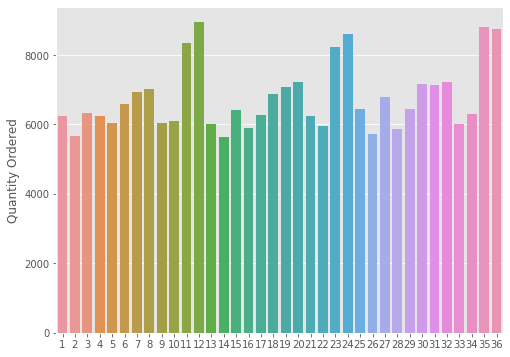

In [4]:
# look at actual month sales

month_sales = df.groupby(['Year', 'Month']).sum().reset_index()
month_sales.index += 1

plt.figure(figsize=(8,6))  # figsize not applying for some reason
ax = sns.barplot(x=month_sales.index, y=month_sales['Quantity Ordered'])

This helps us size the total market. The idea is that we can estimate the total realistic output from the restaurant, and then apply modifiers to decrease from there. 

# 2. What do people spend on orders?

I peeked at yelp too for input and considered scraping them for ratings, but their robot.txt disallows it.

# Improvements

Quantity ordered is big at 1, then 2, then follows a normal distribution after that. It sticks out a bit that as many people ordered 9 quantity of an item as 3 quantity. Maybe a geometric distribution would be more appropriate.

# Data re-generator

I'm going to talk about regenerating data for the A/B test now. Chronologically, this takes place AFTER the analysis and writing out the experiment. If you want to read those first, the links are here:

We regenerate fresh data to simulate collection of user data. 

Current plan is slight random variance in weights, and printing out the weight used to a .txt file which I won't look at until after the analysis. The goal is to evaluate whether or not the value went up or down, and whether it's statistically significant or just noise (e.g. the change we made actually had some impact). 

I'll look at the randomly printed value afterwards to compare. Might make a note: based on the test results, I would say this is statistically significant and would recommend this change going forward. Bonus: since it's a simulation, I'll try to guess the weight (not really sure if this is worth anything since there's so many random variation all over the place, but it's just for fun).